In [1]:
!pip -q install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:06<00:00, 222MB/s]
100% 1.33G/1.33G [00:06<00:00, 206MB/s]


In [2]:
!unzip -q '/content/celeba-dataset.zip'

In [7]:
!rm /content/celeba-dataset.zip

In [1]:
import os
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
%reload_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

In [2]:
SAMPLE_DIR = 'Generated Images'
os.makedirs(SAMPLE_DIR, exist_ok=True)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [4]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

Starting epoch: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch [1/10]                Loss D: -11.8384, loss G: 96.1013
Saving GeneratedIMG-0000.png
Starting epoch: 2



Starting epoch: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch [3/10]                Loss D: -6.2656, loss G: 104.4553
Saving GeneratedIMG-0002.png
Starting epoch: 4



Starting epoch: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch [5/10]                Loss D: -2.8122, loss G: 96.1013
Saving GeneratedIMG-0004.png
Starting epoch: 6



Starting epoch: 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch [7/10]                Loss D: -4.1051, loss G: 64.2103
Saving GeneratedIMG-0006.png
Starting epoch: 8



Starting epoch: 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch [9/10]                Loss D: -1.9126, loss G: 34.0349
Saving GeneratedIMG-0008.png
Starting epoch: 10


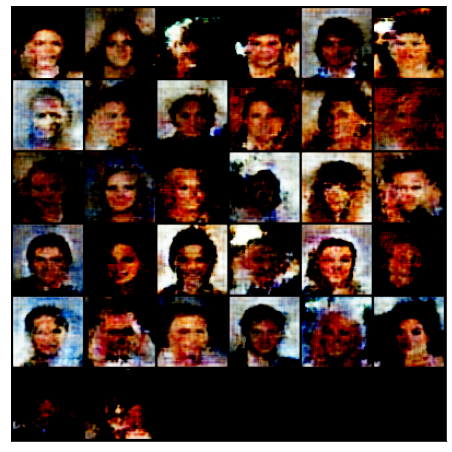

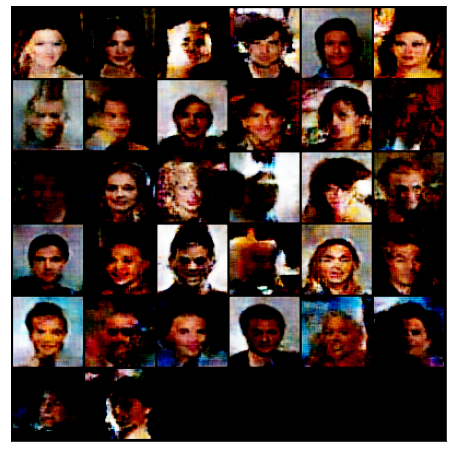

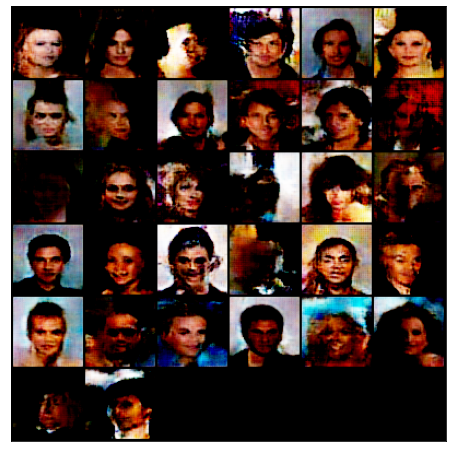

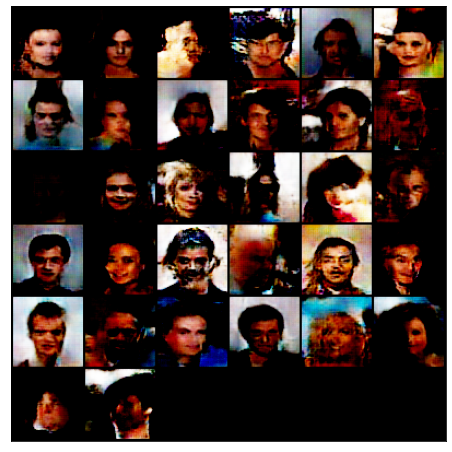

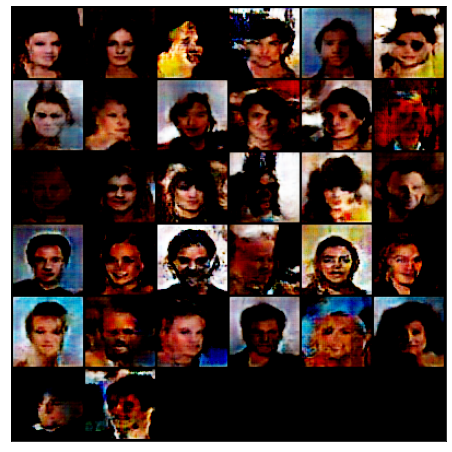

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 72
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

tfm = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

dataset = datasets.ImageFolder(root='/content/img_align_celeba', transform=tfm)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
step = 0

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    print("Starting epoch:", epoch+1)
    tqdm_loader = tqdm(loader, desc='Training', total=len(loader))
    for batch_idx, (real, _) in enumerate(tqdm_loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    if epoch % 2 == 0:
        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}]  \
              Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
        )

        with torch.no_grad():
            fake = gen(fixed_noise)
            img_grid_real = torchvision.utils.make_grid(real[:24], normalize=True)
            img_grid_fake = torchvision.utils.make_grid(fake[:24], normalize=True)
            fake_fname = 'GeneratedIMG-{0:0=4d}.png'.format(epoch)
            denorm_fake_images = fake*0.5 + 0.5
            save_image(denorm_fake_images, os.path.join(SAMPLE_DIR, fake_fname), nrow=6)
            print('Saving', fake_fname)
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(torchvision.utils.make_grid(fake.cpu().detach(), nrow=6).permute(1, 2, 0))

        step += 1